In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import argparse
from sklearn.metrics import roc_curve as ROC
from sklearn.metrics import auc,brier_score_loss

import matplotlib
import matplotlib.pyplot as plt

from Utils.loading import *
from Utils.treino import *
from Utils.init_redes import *
from Utils.KD import *
from Utils.ensemble import *
from Utils.redes import *
from Utils.data_set import *
from Utils.cobertura import *
from Utils.graficos import *

In [2]:
if torch.cuda.is_available():
    device = 'cuda'  
else:
    device = 'cpu'
print(device)

cuda


In [3]:
data_set = "Cifar100"

if data_set == "Cifar10":
    transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader, classes = cifar10()
elif data_set == "Cifar100":
    transform_train, transform_test, batch_size, trainset, trainloader, testset, testloader= cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [16]:
# ENEMBLE T IGUAIS

models = load_cifar100(2)

correct_list = list()
covarege_list = list()
auc_list = list()
auroc_list = list()

n_redes = 2

outputs = torch.tensor([]).to("cuda")
labels_cat = torch.tensor([])

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data

        outputs_0 = caculate_outputs(models[0:n_redes],images.to("cuda"))
        outputs_0 = torch.stack(tuple(outputs_0),dim=0)
        outputs = torch.cat((outputs,outputs_0),dim=1)
        labels_cat = torch.cat((labels_cat,labels),dim=0) # Junta as respostas

valores = np.arange(0.01,5.01,0.01)

for valor in valores:
    T = valor

    output0 = outputs[0]/T
    output1 = outputs[1]/T
    outputs_stack = torch.stack((output0,output1),dim=0)

    outputs_mean = torch.mean(outputs_stack, dim=0)
    outputs_softmax = torch.nn.functional.softmax(outputs_mean, dim=-1)
    
    uncs, _, _, predict = calculate_predicted(outputs_softmax)
    correct_list.append(calculate_correct(predict, labels_cat))
    covarege_list.append(RC_curve(predict,labels_cat.to("cuda"),uncs))
    auc_list.append(AURC(predict, labels_cat.to("cuda"), uncs))
    auroc_list.append(AUROC(predict, labels_cat.to("cuda"), uncs))
    
    
    
# ENEMBLE T DIFERENTES

correct_list_Tdif = list()
covarege_list_Tdif = list()
auc_list_Tdif = list()
auroc_list_Tdif = list()


outputs2 = torch.tensor([]).to("cuda")

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data

        outputs_0 = caculate_outputs(models[0:n_redes],images.to("cuda"))
        outputs_0 = torch.stack(tuple(outputs_0),dim=0)
        outputs2 = torch.cat((outputs2,outputs_0),dim=1)

valores1 = np.arange(0.01,5.01,0.01)
valores2 = np.arange(0.01,5.01,0.01)
i = 0

for valor1 in valores1:
    T1 = valor1
    print(i, end=" ")
    i += 1
    for valor2 in valores2:
        T2 = valor2

        output0 = outputs2[0]/T1
        output1 = outputs2[1]/T2
        outputs_stack2 = torch.stack((output0,output1),dim=0)

        outputs_mean2 = torch.mean(outputs_stack2, dim=0)
        outputs_softmax2 = torch.nn.functional.softmax(outputs_mean2, dim=-1)
    
        uncs, _, _, predict = calculate_predicted(outputs_softmax)

        correct_list_Tdif.append(calculate_correct(predict, labels_cat))
        covarege_list_Tdif.append(RC_curve(predict,labels_cat.to("cuda"),uncs))
        auc_list_Tdif.append(AURC(predict, labels_cat.to("cuda"), uncs))
        auroc_list_Tdif.append(AUROC(predict, labels_cat.to("cuda"), uncs))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

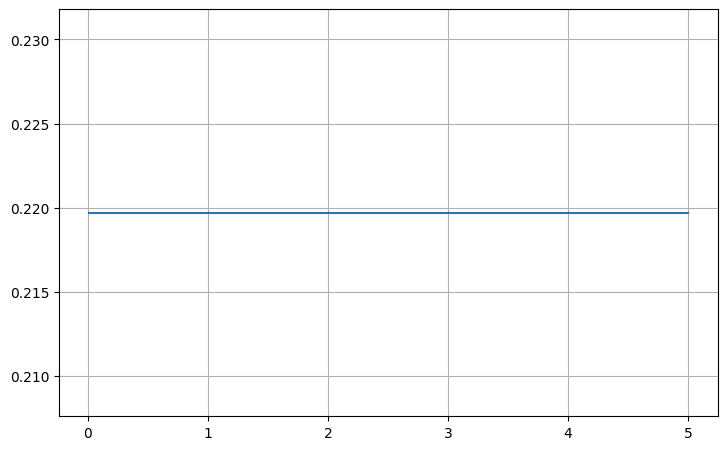

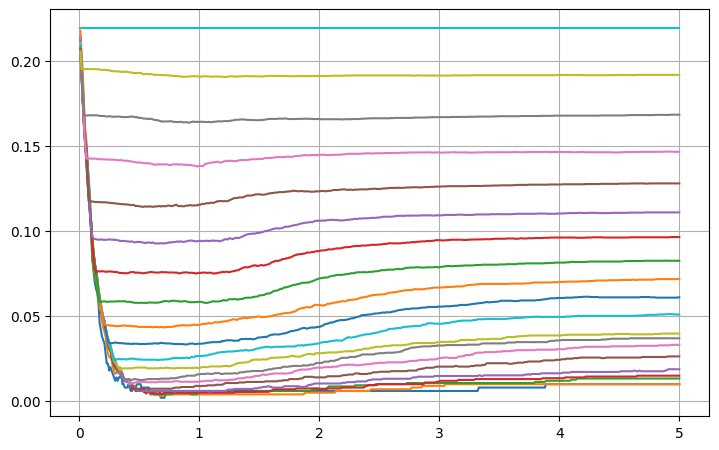

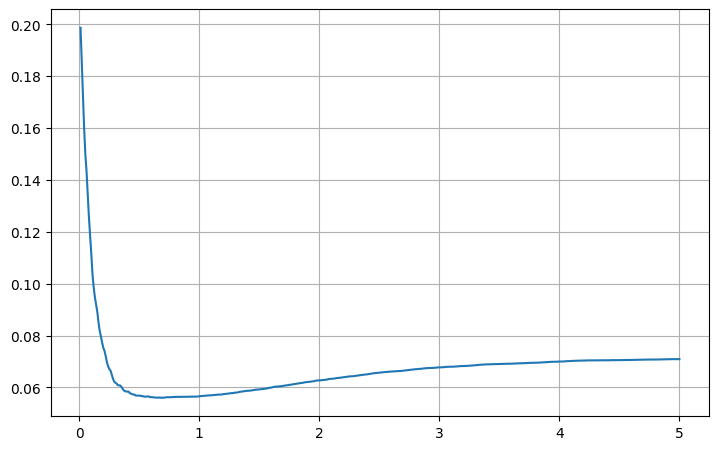

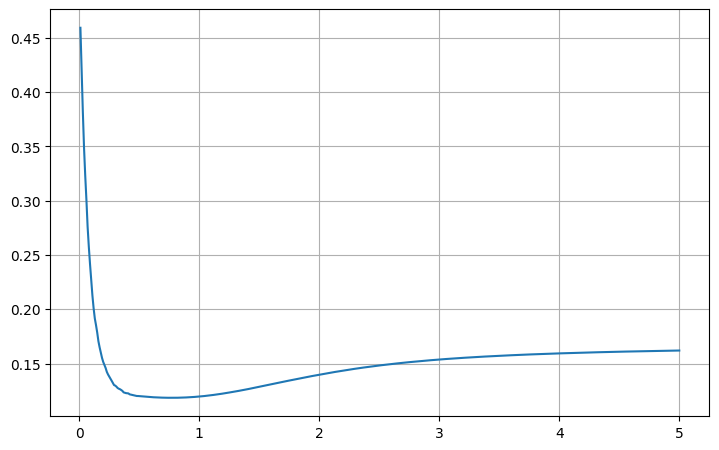

Valor de T:  0.68 Acuracia: 78.03 Ponto minimo do AURC 0.0559900726500881 78.03 Ponto minimo do AUROC: 0.11846172629121382


In [24]:
T = np.arange(0.01,5.01,0.01)

g1 = plot_graph(T,correct_list)

g2 = plot_graph(T,covarege_list)

g3 = plot_graph(T,auc_list)

g4 = plot_graph(T,auroc_list)

#g2.savefig("./Graficos/Temperatura/Cifar100/Normal/AUC_Ensemble.jpeg")
#g1.savefig("./Graficos/Temperatura/Cifar100/Normal/acuracia_Ensemble.jpeg")

plt.show()

t = T[auc_list.index(min(auc_list))]
acuracia = (1-correct_list[auc_list.index(min(auc_list))])*100
print("Valor de T: ", t, "Acuracia:", acuracia, "Ponto minimo do AURC", min(auc_list), acuracia, "Ponto minimo do AUROC:", min(auroc_list))

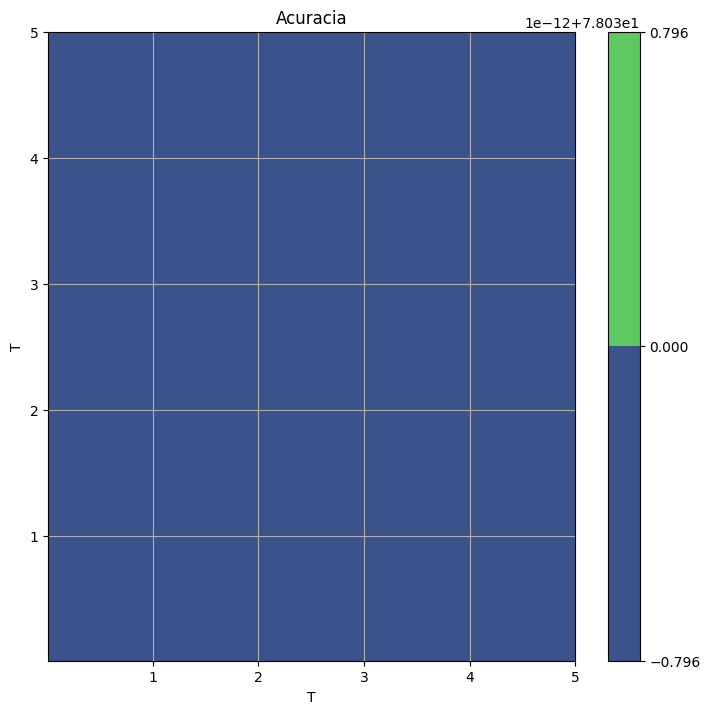

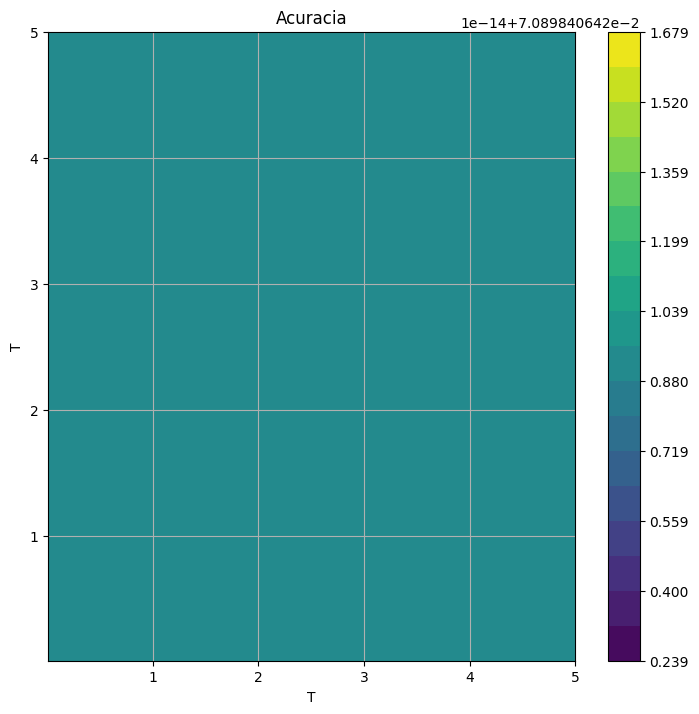

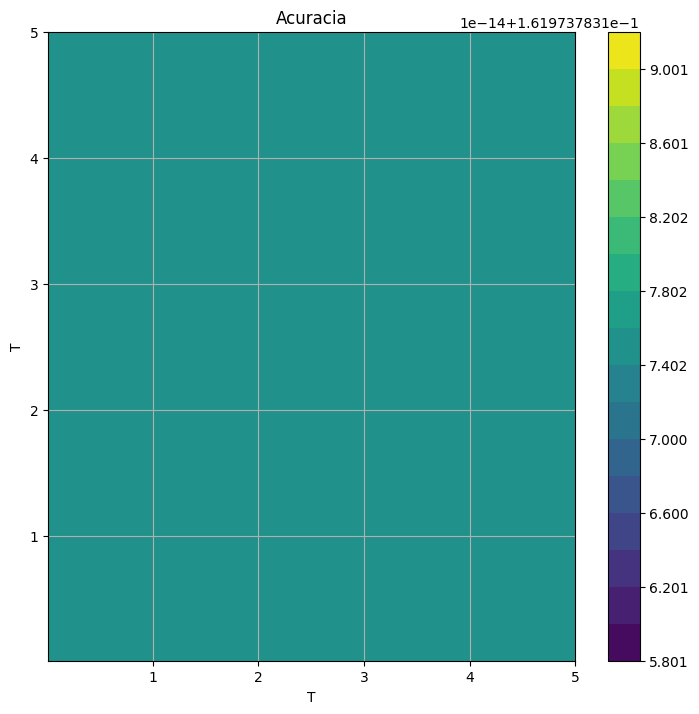

In [31]:
X, Y = np.meshgrid(T, T)

fig2 = plt.figure()
fig2.set_size_inches(8.5, 8.5)
ax2 = fig2.add_subplot()
fig2.subplots_adjust(top=0.85)
ax2.set_title("Acuracia")
ax2.set_xlabel("T")
ax2.set_ylabel("T")
pos2 = ax2.get_position()

index = 0
Correct = list()
for i in range(500):
    aux = list()
    for j in range(500):
        aux.append((1-correct_list_Tdif[index])*100)
        index += 1
    Correct.append(aux)

ax2 = ax2.contourf(X, Y, Correct, levels=20)
ax2.changed()
cbar2 = plt.colorbar(ax2)

plt.grid()
plt.show()


#fig1 = plt.figure()
#fig1.set_size_inches(8.5, 8.5)
#ax1 = fig1.add_subplot()
#fig1.subplots_adjust(top=0.85)
#ax1.set_title("AUC")
#ax1.set_xlabel("T")
#ax1.set_ylabel("T")
#pos1 = ax1.get_position()


#index = 0
#AUC = list()
#for i in range(500):
#    aux = list()
#    for j in range(500):
#        aux.append(covarege_list_Tdif[index])
#        index += 1
#    AUC.append(aux)
#
#ax1 = ax1.contourf(X, Y, AUC, levels=20)
#ax1.changed()
#cbar = plt.colorbar(ax1)


#plt.grid()
#plt.show()

fig3 = plt.figure()
fig3.set_size_inches(8.5, 8.5)
ax3 = fig3.add_subplot()
fig3.subplots_adjust(top=0.85)
ax3.set_title("Acuracia")
ax3.set_xlabel("T")
ax3.set_ylabel("T")
pos3 = ax3.get_position()

index = 0
auc = list()
for i in range(500):
    aux = list()
    for j in range(500):
        aux.append(auc_list_Tdif[index])
        index += 1
    auc.append(aux)

ax3 = ax3.contourf(X, Y, auc, levels=20)
ax3.changed()
cbar3 = plt.colorbar(ax3)

plt.grid()
plt.show()

fig4 = plt.figure()
fig4.set_size_inches(8.5, 8.5)
ax4 = fig4.add_subplot()
fig4.subplots_adjust(top=0.85)
ax4.set_title("Acuracia")
ax4.set_xlabel("T")
ax4.set_ylabel("T")
pos4 = ax4.get_position()

index = 0
auroc = list()
for i in range(500):
    aux = list()
    for j in range(500):
        aux.append(auroc_list_Tdif[index])
        index += 1
    auroc.append(aux)

ax4 = ax4.contourf(X, Y, auroc, levels=20)
ax4.changed()
cbar4 = plt.colorbar(ax4)

plt.grid()
plt.show()

#fig1.savefig("./Graficos/Temperatura/Cifar100/Meansoft/AUC_Tdifs.jpeg")
#fig2.savefig("./Graficos/Temperatura/Cifar100/Meansoft/acuracia_Tdifs.jpeg")

valor12=list()
valor22=list()

for i in T:
    for j in T:
        valor12.append(i)
        valor22.append(j)
        
#t12 = valor12[auc22.index(min(auc22))]
#t22 = valor22[auc22.index(min(auc22))]
#acuracia2 = (1-correct22[auc22.index(min(auc22))])*100
#print(t12,t22, min(auc22), acuracia2)